In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
from category_encoders import OneHotEncoder

## Przygotowanie danych 

In [2]:
data=pd.DataFrame(pd.read_json('https://api.apispreadsheets.com/api/dataset/school-grades/',orient='split'))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    

## Inżynieria cech 
### Kodowanie kategoryczne i dodanie kolumny "Czy dostał 0 pkt"

Chcąc lepiej przewidywać wyniki postanowiliśmy inaczej potraktować osoby z zerowym wynikiem. Nasz plan jest taki, aby najpierw przewidywać czy osoba dostanie 0 pkt, a następnie, jeśli z przewidywania wyjdzie że nie powinna dostać 0 pkt, przewidujemy jej wynik.

In [3]:
data['schoolsup'].describe()

count     649
unique      2
top        no
freq      581
Name: schoolsup, dtype: object

Wyrzucamy również kolumne dotyczącą edukacji ojca, gdyż z EDA wyszło nam że jest ona mocno skorelowana z edukacją matki. Postanowiliśmy wyrzucić jedną z tych cech.

In [4]:
data = data.drop(labels = "Fedu", axis = 1)
data = data.drop(labels = "Fjob", axis = 1)

ce_one_hot = OneHotEncoder(cols = ("Mjob", "sex", "school",'famsize',
                                   "address", "Pstatus", "reason",
                                   "guardian", "schoolsup",'famsup', 'paid',
                                   'activities', 'nursery', 'higher', 'internet', 'romantic' ))
df = ce_one_hot.fit_transform(data)

In [5]:
a=df.shape[1]-3
df_G=df.iloc[:,:a]

a=df.shape[1]-1
df=df.iloc[:,:a]
data['is_zero']=np.where(data['G3']==0,0,1)

df.head()

,school_1,school_2,sex_1,sex_2,age,address_1,address_2,famsize_1,famsize_2,Pstatus_1,...,romantic_2,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2
0,1,0,1,0,18,1,0,1,0,1,...,0,4,3,4,1,1,3,4,0,11
1,1,0,1,0,17,1,0,1,0,0,...,0,5,3,3,1,1,3,2,9,11
2,1,0,1,0,15,1,0,0,1,0,...,0,4,3,2,2,3,3,6,12,13
3,1,0,1,0,15,1,0,1,0,0,...,1,3,2,2,1,1,5,0,14,14
4,1,0,1,0,16,1,0,1,0,0,...,0,4,3,2,1,2,5,0,11,13


## Modele

In [6]:
## Funkcja pomocnicza do testowania modeli 

def models_score(model_params, x_train, y_train, x_test, y_test):
    results=[]
    for name, param in model_params.items():
        classifier=GridSearchCV(param['model'],param['params'],cv=6,return_train_score=False)
        classifier.fit(x_train,  y_train)
        model_performance = np.sqrt(mean_squared_error(classifier.predict(x_test),y_test, squared=True))
        results.append({
            'model': name,
            'best_score': classifier.best_score_,
            'best_params': classifier.best_params_,
            'RMSE': model_performance
        })
    return results

def draw_hists(model, x_test, y_test):
    fig, ax =plt.subplots(1,2, sharey=True, figsize=(12,6))
    sns.histplot(clf.predict(x_test), ax=ax[0])
    sns.histplot(y_test, ax=ax[1])
    ax[0].set_title('Rozkład przewidywany')
    ax[1].set_title('Rozkład rzeczywisty')
    fig.show()

### Regrasja bez podziału na uczniów, którzy dostali 0pkt

In [7]:
x_train, x_test, y_train, y_test = train_test_split(df, data["G3"],test_size=0.3, random_state=0)
x_train_G, x_test_G, y_train_G, y_test_G = train_test_split(df_G, data["G3"],test_size=0.3, random_state=0)

model_params1={
    'linear_regression':{
        'model': linear_model.LinearRegression(),
        'params': {}
    },
    'lasso':{
        'model': linear_model.Lasso(random_state=15),
        'params':{
            'alpha':[0.1,1,0],
            'normalize':['True','False']
        }
    },
    'svm':{
            'model': svm.SVC(gamma='auto', tol=1e-1, cache_size=2000, max_iter=1500),
            'params': {
                'C': [0.001, 0.01, 0.1, 1, 3, 10, 30],
                'kernel': ['linear', 'rbf']
            }
    }
}

#### Wyniki z G1 i G2

In [8]:
results= models_score(model_params1, x_train, y_train, x_test, y_test)
results

[{'model': 'linear_regression',
  'best_score': 0.826048271365063,
  'best_params': {},
  'RMSE': 1.3448902385469212},
 {'model': 'lasso',
  'best_score': 0.8260792371131339,
  'best_params': {'alpha': 0, 'normalize': 'True'},
  'RMSE': 1.3384449713763498},
 {'model': 'svm',
  'best_score': 0.4163157894736842,
  'best_params': {'C': 0.1, 'kernel': 'linear'},
  'RMSE': 1.6235447132424274}]

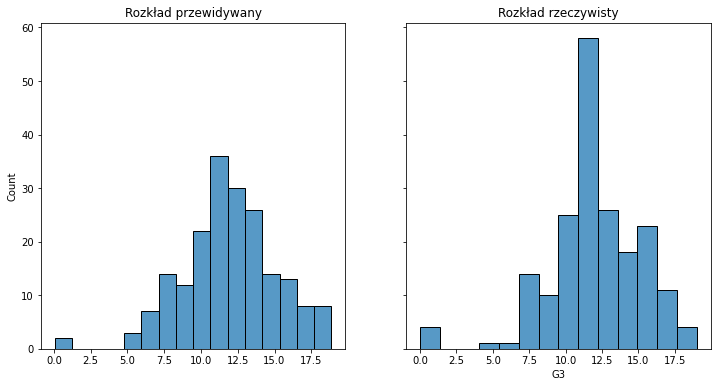

In [9]:
clf = linear_model.Lasso(alpha=0, normalize = True).fit(x_train, y_train)
draw_hists(clf, x_test, y_test)

#### Wyniki bez G1 i G2

In [10]:
results= models_score(model_params1, x_train_G, y_train_G, x_test_G, y_test_G)
results

[{'model': 'linear_regression',
  'best_score': 0.21248193055614717,
  'best_params': {},
  'RMSE': 2.658618691346799},
 {'model': 'lasso',
  'best_score': 0.21121308154841392,
  'best_params': {'alpha': 0, 'normalize': 'True'},
  'RMSE': 2.649300622572791},
 {'model': 'svm',
  'best_score': 0.21160818713450294,
  'best_params': {'C': 3, 'kernel': 'rbf'},
  'RMSE': 3.550370150438994}]

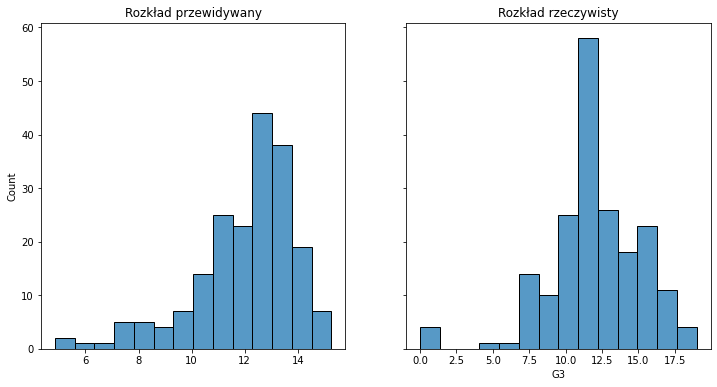

In [11]:
clf = linear_model.Lasso(alpha=0, normalize = True).fit(x_train_G, y_train_G)
draw_hists(clf, x_test_G, y_test_G)

### Klasyfikacja uczniów z zerowym wynikiem 

In [12]:
 x_train2, x_test2, y_train2, y_test2 = train_test_split(df, data["is_zero"],test_size=0.3, random_state=13)

In [13]:

from sklearn.linear_model import LogisticRegression

model_params2={
    'random_forest':{
        'model': RandomForestClassifier(random_state=15),
        'params': {
            'n_estimators':[1,3,8,13],
            'min_samples_split': [3,5,10,20]
        }
    },
    'logistic_regession':{
        'model': LogisticRegression(random_state=15, solver='liblinear'),
        'params':{
            'C':[1,5,10],
            'penalty':['l1','l2','elasticnet']
        }
    },
    'svm':{
            'model': svm.SVC(gamma='auto', tol=1e-1, cache_size=2000, max_iter=1500),
            'params': {
                'C': [0.001, 0.01, 0.1, 1, 3, 10, 30],
                'kernel': ['linear', 'rbf']
            }
    }
}

In [14]:
results_isZero= models_score(model_params2, x_train2, y_train2, x_test2, y_test2)
results_isZero

[{'model': 'random_forest',
  'best_score': 0.9846198830409355,
  'best_params': {'min_samples_split': 3, 'n_estimators': 8},
  'RMSE': 0.10127393670836667},
 {'model': 'logistic_regession',
  'best_score': 0.9823976608187134,
  'best_params': {'C': 1, 'penalty': 'l1'},
  'RMSE': 0.0},
 {'model': 'svm',
  'best_score': 0.9868128654970759,
  'best_params': {'C': 0.01, 'kernel': 'linear'},
  'RMSE': 0.10127393670836667}]

### Regrasja tylko dla uczniów, którzy nie dostali zero punktów 

In [15]:
only_good_data=df.loc[data.is_zero==1]
data2=data.loc[data.is_zero==1]
x_train3, x_test3, y_train3, y_test3 = train_test_split(only_good_data, data2["G3"],test_size=0.3, random_state=0)

In [16]:
model_params3={
    'linear_regression':{
        'model': linear_model.LinearRegression(),
        'params': {}
    },
    'lasso':{
        'model': linear_model.Lasso(random_state=15),
        'params':{
            'alpha':[0.1,1,0],
            'normalize':['True','False']
        }
    }
}

In [17]:
results3= models_score(model_params3, x_train3, y_train3, x_test3, y_test3)
results3                                                      

[{'model': 'linear_regression',
  'best_score': 0.8660971870949128,
  'best_params': {},
  'RMSE': 0.9344239094562881},
 {'model': 'lasso',
  'best_score': 0.8655754653074229,
  'best_params': {'alpha': 0, 'normalize': 'True'},
  'RMSE': 0.9344510773077692}]

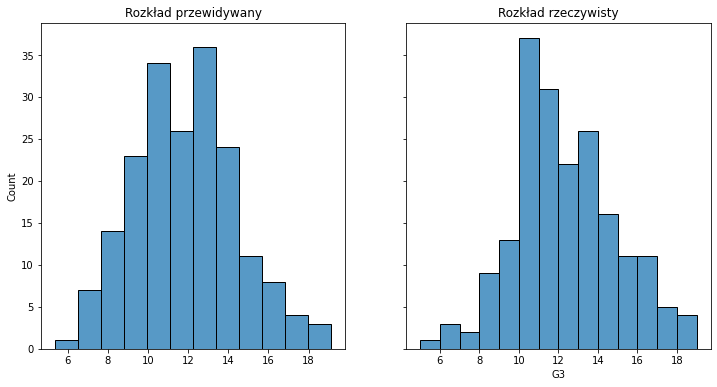

In [18]:
clf = linear_model.LinearRegression().fit(x_train3, y_train3)
draw_hists(clf, x_test3, y_test3)

# Model z kubełkami 


In [19]:
data_bins = data.drop(labels = "is_zero", axis = 1)

In [20]:
## Podział na kubełki 
def divade(x, n):
    return (x//n) * n 

df_bins = data_bins["G3"].apply(lambda x: divade(x, 4))

x_train4, x_test4, y_train4, y_test4 = train_test_split(df, df_bins,test_size=0.3, random_state=0)

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

model_params4={
    'random_forest':{
        'model': RandomForestClassifier(random_state=15),
        'params': {
            'n_estimators':[1,3,8,13],
            'min_samples_split': [3,5,10,20]
        }
    },
    'logistic_regession':{
        'model': LogisticRegression(random_state=15, solver='liblinear'),
        'params':{
            'C':[1,5,10],
            'penalty':['l1','l2','elasticnet']
        }
    },
    'svm':{
            'model': svm.SVC(gamma='auto', tol=1e-1, cache_size=2000, max_iter=1500),
            'params': {
                'C': [0.001, 0.01, 0.1, 1, 3, 10, 30],
                'kernel': ['linear', 'rbf']
            }
    }
}

In [22]:
results4= models_score(model_params4, x_train4, y_train4, x_test4, y_test4)
results4   

[{'model': 'random_forest',
  'best_score': 0.8392397660818715,
  'best_params': {'min_samples_split': 3, 'n_estimators': 13},
  'RMSE': 1.900067475185134},
 {'model': 'logistic_regession',
  'best_score': 0.7291520467836258,
  'best_params': {'C': 5, 'penalty': 'l1'},
  'RMSE': 2.2002330878853815},
 {'model': 'svm',
  'best_score': 0.85453216374269,
  'best_params': {'C': 0.01, 'kernel': 'linear'},
  'RMSE': 1.718675697694639}]

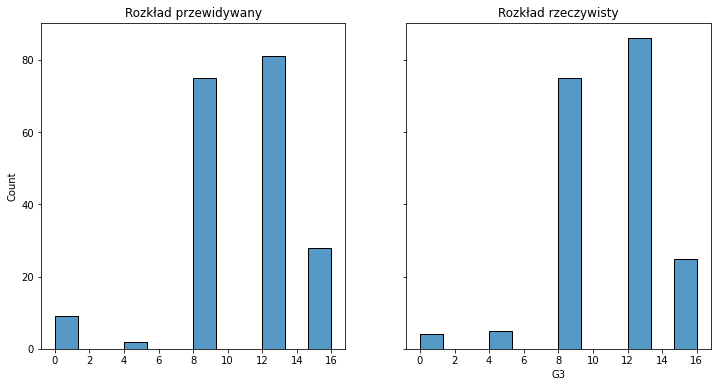

In [23]:
clf = svm.SVC(gamma='auto', tol=1e-1, cache_size=2000, max_iter=1500, C = 5, kernel = 'linear').fit(x_train4, y_train4)
draw_hists(clf, x_test4, y_test4)